In [33]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision.transforms as transforms
import cv2
import os
import random
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from torch import nn
import torch.nn.functional as F
from torch.optim import Optimizer
from torch.optim.lr_scheduler import StepLR
import copy
from tqdm import tqdm
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)




cuda:0


In [34]:

#load the data into torchvision.datasets
trainset = datasets.CIFAR10(root='./', train=True, download=False, transform=transforms.ToTensor())
batch_size = 32
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

testset = datasets.CIFAR10(root='./', train=False, download=False, transform=transforms.ToTensor())
test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

# 10 classes in CIFAR-10
class_names = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']

In [35]:
# Print the keys of the data
print(trainset.data.shape)
print(testset.data.shape)

(50000, 32, 32, 3)
(10000, 32, 32, 3)


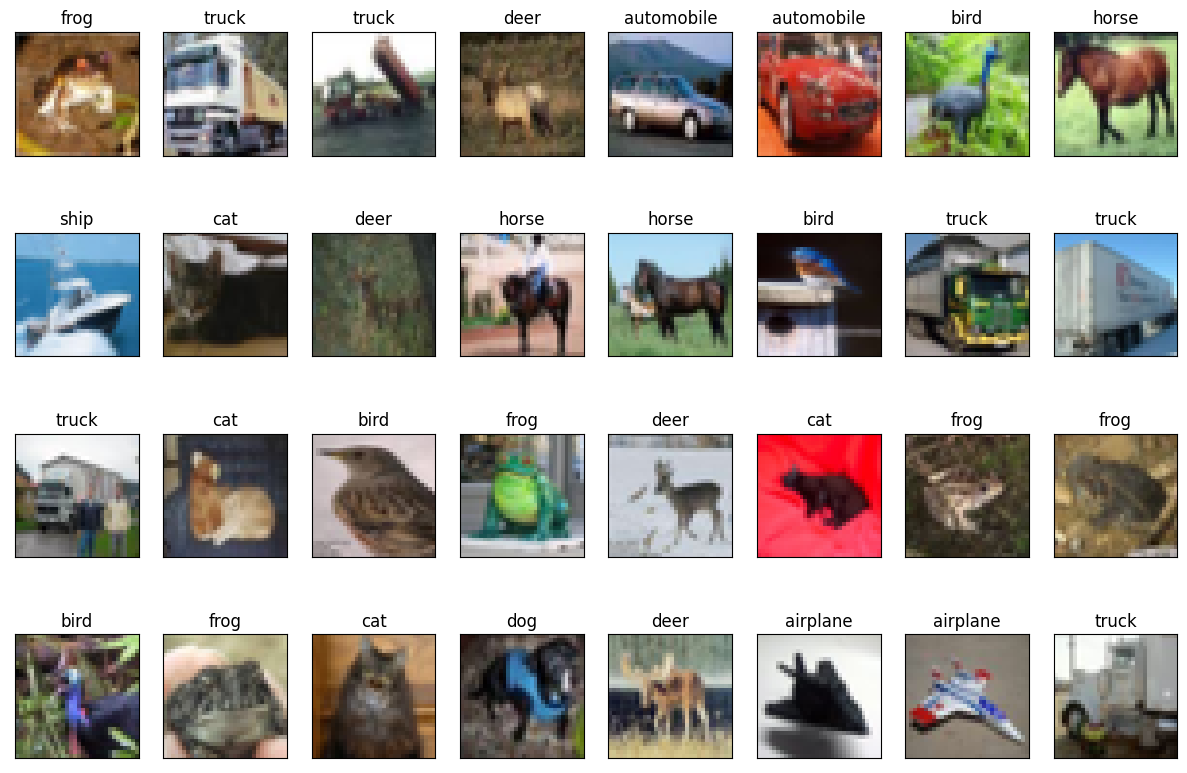

In [36]:
# Plot some images
plt.figure(figsize=(15,10))
for i in range(batch_size):
    plt.subplot(4, 8, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(trainset.data[i])
    plt.title(class_names[trainset.targets[i]])





In [37]:
class LeNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 5, 1, padding=2)
        self.bn1 = nn.BatchNorm2d(32)  # Batch normalization after the first convolutional layer
        self.conv2 = nn.Conv2d(32, 64, 3, 1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 64, 3, 1, padding=1)
        self.bn3 = nn.BatchNorm2d(64)  # Batch normalization after the third convolutional layer
        self.conv4 = nn.Conv2d(64, 128, 3, 1, padding=1)
        self.bn4 = nn.BatchNorm2d(128)  # Batch normalization after the third convolutional layer
        self.conv5 = nn.Conv2d(128, 128, 3, 1, padding=1)
        self.bn5 = nn.BatchNorm2d(128)
        self.fc1 = nn.Linear(4 * 4 * 128, 512)
        self.fc2 = nn.Linear(512,256)
        self.dropout = nn.Dropout(0.5)
        self.fc3 = nn.Linear(256, 10)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.max_pool2d(x, 2, 2)
        x = self.dropout(x)
        
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = F.max_pool2d(x, 2, 2)
        x = self.dropout(x) 
        
        x = F.relu(self.bn5(self.conv5(x)))
        x = F.max_pool2d(x, 2, 2)
        x = self.dropout(x)
        
        x = x.view(-1, 4 * 4 * 128)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        
        return x


In [38]:
model = LeNet().to(device)
print(model)

LeNet(
  (conv1): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=2048, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (dropout): Dropout(p=0.5, inplac

In [39]:
# Define the loss function and optimizer
learning_rate = 0.001
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


In [40]:
# # Train the model
# num_epochs = 100   # Adjust the number of epochs as needed
# train_loss_list = []
# val_loss_list = []
# train_acc_list = []
# val_acc_list = []

# for epoch in range(num_epochs):
#     model.train()  # Set the model to training mode
#     total_correct_train = 0
#     total_samples_train = 0
#     epoch_loss_train = 0
    
#     # Training loop
#     for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs} (Training)", leave=False):
#         inputs, labels = inputs.to(device), labels.to(device)

#         optimizer.zero_grad()
#         outputs = model(inputs)
#         loss = criterion(outputs, labels)

#         total_correct_train += (outputs.argmax(1) == labels).sum().item()
#         total_samples_train += labels.size(0)
#         epoch_loss_train += loss.item()

#         loss.backward()
#         optimizer.step()

#     average_epoch_loss_train = epoch_loss_train / len(train_loader)
#     train_loss_list.append(average_epoch_loss_train)
#     train_acc = total_correct_train / total_samples_train * 100
#     train_acc_list.append(train_acc)

#     # Validation loop
#     model.eval()  # Set the model to evaluation mode
#     total_correct_val = 0
#     total_samples_val = 0
#     epoch_loss_val = 0

#     with torch.no_grad():
#         for val_inputs, val_labels in tqdm(test_loader, desc=f"Epoch {epoch + 1}/{num_epochs} (Validation)", leave=False):
#             val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)

#             val_outputs = model(val_inputs)
#             val_loss = criterion(val_outputs, val_labels)

#             total_correct_val += (val_outputs.argmax(1) == val_labels).sum().item()
#             total_samples_val += val_labels.size(0)
#             epoch_loss_val += val_loss.item()

#     average_epoch_loss_val = epoch_loss_val / len(test_loader)
#     val_loss_list.append(average_epoch_loss_val)
#     val_acc = total_correct_val / total_samples_val * 100
#     val_acc_list.append(val_acc)

#     print(f"Epoch [{str(epoch + 1).zfill(2)}/{str(num_epochs).zfill(2)}], Train Loss: {average_epoch_loss_train:.4f}, Train Acc: {train_acc:.2f}%, Val Loss: {average_epoch_loss_val:.4f}, Val Acc: {val_acc:.2f}%")


# # Save the trained model if needed
# torch.save(model.state_dict(), 'lenet_model.pth')

In [41]:
# # Plot training and validation loss
# plt.figure(figsize=(10, 8))

# # Subplot 1: Training and Validation Loss
# plt.subplot(2, 1, 1)
# plt.plot(train_loss_list, label='Training Loss', color='blue')
# plt.plot(val_loss_list, label='Validation Loss', color='orange')
# plt.xlabel("Epoch")
# plt.ylabel("Loss")
# plt.title("Training and Validation Loss vs Epoch")
# plt.legend()

# # Subplot 2: Training and Validation Accuracy
# plt.subplot(2, 1, 2)
# plt.plot(train_acc_list, label='Training Accuracy', color='green')
# plt.plot(val_acc_list, label='Validation Accuracy', color='red')
# plt.xlabel("Epoch")
# plt.ylabel("Accuracy (%)")
# plt.title("Training and Validation Accuracy vs Epoch")
# plt.legend()

# plt.tight_layout()
# plt.show()


In [42]:
# if model is already trained, load the model
model.load_state_dict(torch.load('lenet_model.pth'))

<All keys matched successfully>

In [43]:
# Test the model
model.eval()  # Set the model to evaluation mode
all_predictions = []
all_labels = []
with torch.no_grad():
    correct = 0
    total = 0
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        outputs = model(inputs)

        # Get predictions
        _, predicted = torch.max(outputs, 1)
        
        # Update lists
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        
        # Update Correct
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(f"Test Accuracy: {100 * correct / total:.4f}%")


Test Accuracy: 85.7000%


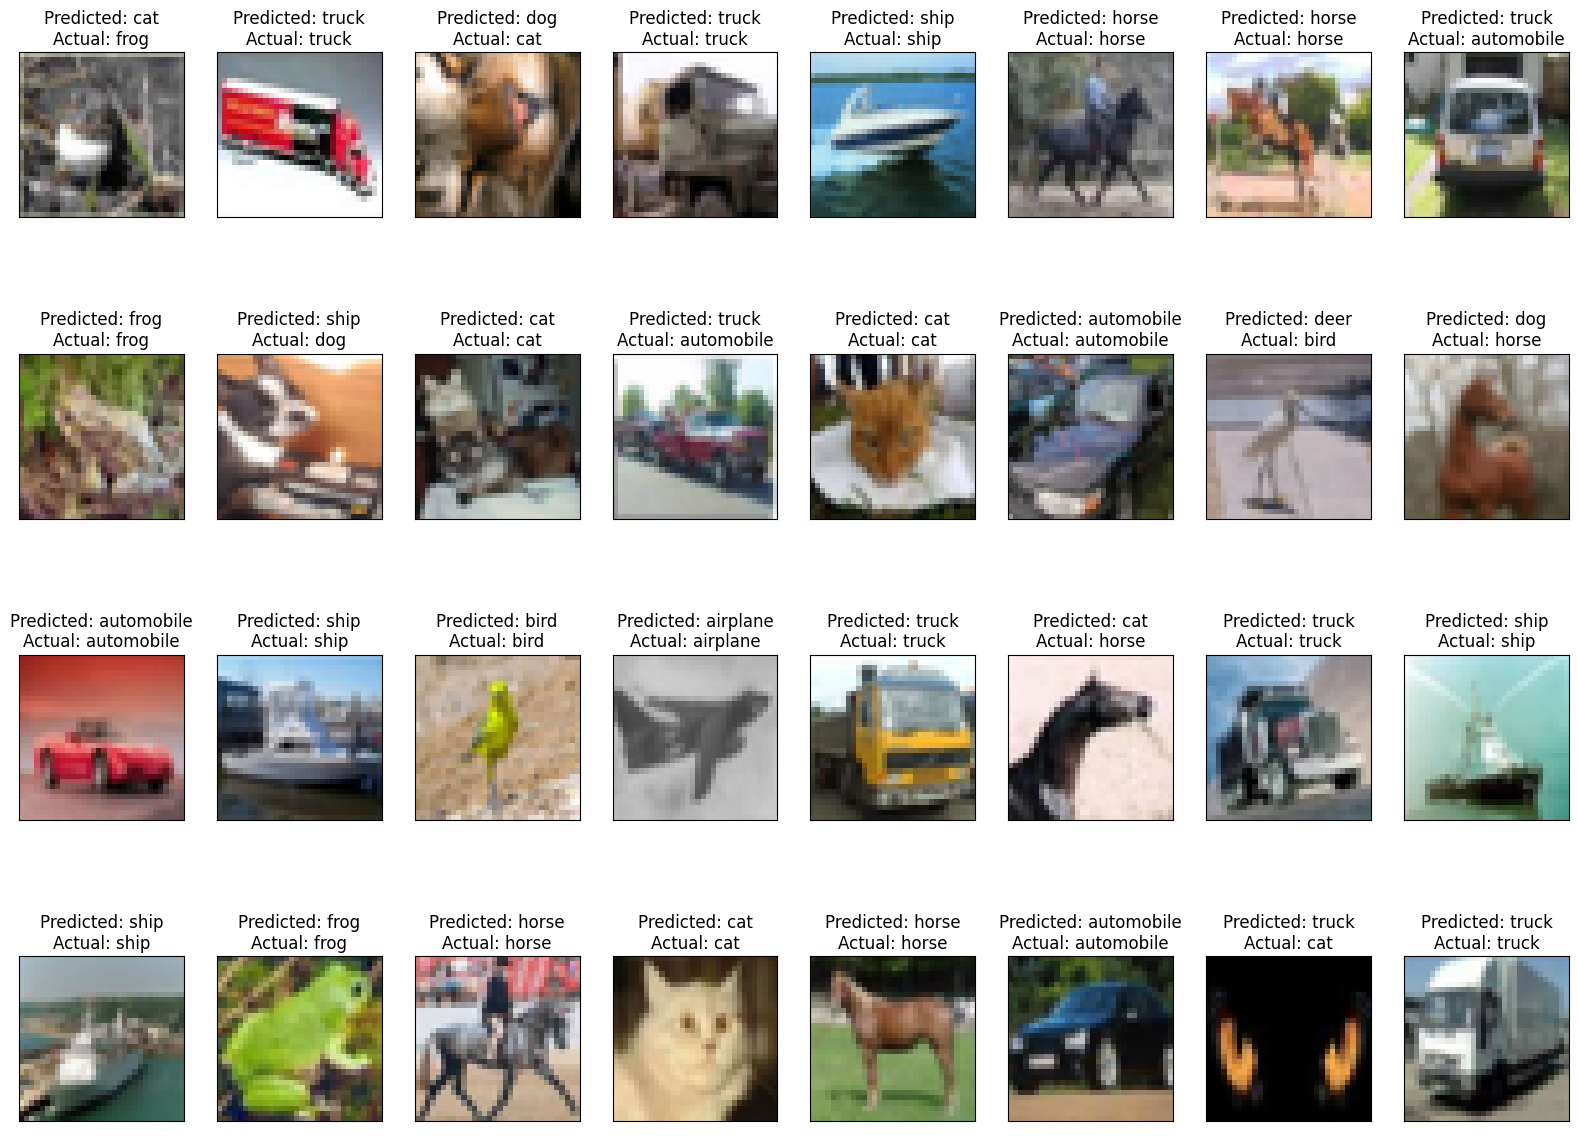

In [44]:
# Get a random batch from the test loader
random_batch_idx = random.randint(0, len(test_loader) - 1)
images, labels = list(test_loader)[random_batch_idx]

# Predict the labels
outputs = model(images.to(device))
_, predicted = torch.max(outputs, 1)

# Plot the images
fig = plt.figure(figsize=(20, 15))
for i in range(batch_size):
    plt.subplot(4, 8, i+1)
    plt.imshow(images[i].permute(1, 2, 0).cpu().numpy())
    plt.title(f'Predicted: {class_names[predicted[i]]}\nActual: {class_names[labels[i].item()]}')
    plt.xticks([])
    plt.yticks([])

plt.show()

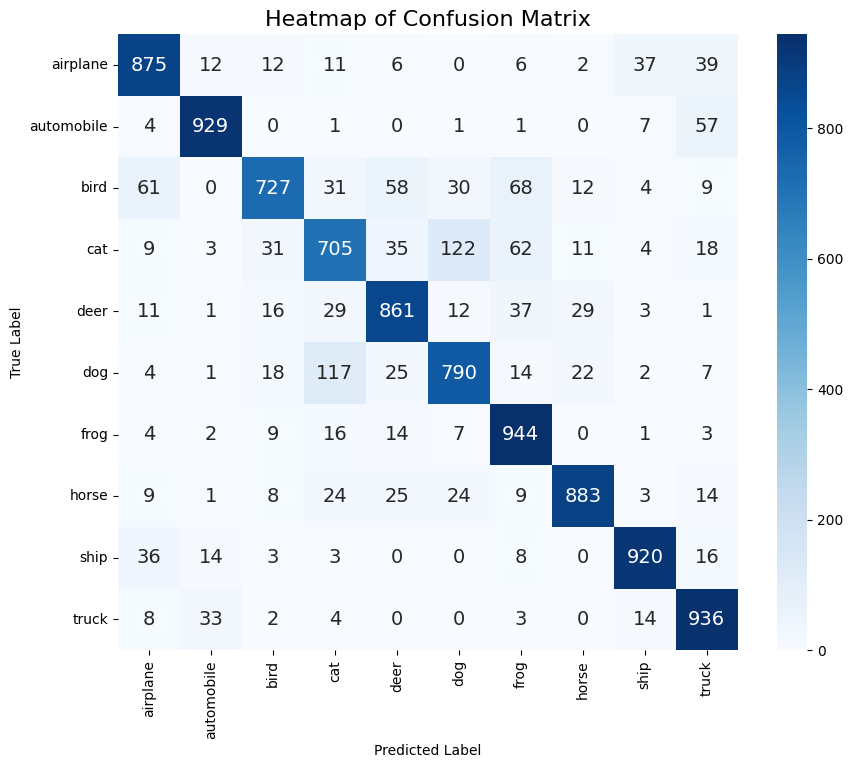

In [45]:
# Confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_predictions)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap=plt.cm.Blues, cbar=True, annot_kws={'size': 14},
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Heatmap of Confusion Matrix', fontsize=16)
plt.show()
